In [291]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Introduction to the Card Dataset and Classification with Imbalanced Data Card Dataset Overview

The card dataset consists of financial transactions and is commonly used for fraud detection tasks. The dataset includes:

Time: Time elapsed since the first transaction in the dataset.
V1 to V28: 28 anonymized features resulting from dimensionality reduction, capturing transaction patterns while protecting sensitive     information.
Amount: Monetary value of the transaction.
Class: Target variable indicating fraud (1) or non-fraud (0).

## Classifying with Highly Imbalanced Datasets

Due to the rarity of fraudulent transactions (about 0.17% of the data), classifying such imbalanced datasets presents significant challenges:

Model Bias: Traditional models may bias towards the majority class (non-fraudulent) and fail to detect the minority class (fraudulent) effectively.
Evaluation Metrics: Accuracy is not a reliable performance metric. Instead, metrics like precision, recall and F1-score should be used.

## Approaches

XGBoost:
    A powerful gradient boosting model that handles class imbalance through parameter tuning and class weight adjustment. It performs well with large datasets and provides robust classification.

LightGBM:
    An efficient gradient boosting framework known for speed and accuracy. It includes options for handling class imbalance and is suitable for large-scale datasets.

Autoencoders:
    A neural network-based approach used for anomaly detection. Autoencoders can learn to reconstruct the majority class and identify anomalies (fraudulent transactions) based on reconstruction error.

These methods can be employed individually or in combination to enhance performance in detecting fraudulent transactions and dealing with class imbalance.

In [293]:
import warnings
warnings.filterwarnings("ignore")

In [348]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# %matplotlib inline

In [389]:
card = pd.read_csv("creditcard.csv", sep = ',')

In [334]:
card.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [336]:
card['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [338]:
## minority class is 0.17% from the entire class
100*(card[card['Class']==1].shape[0]/card.shape[0])

0.1727485630620034

In [340]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Distribution of the variables

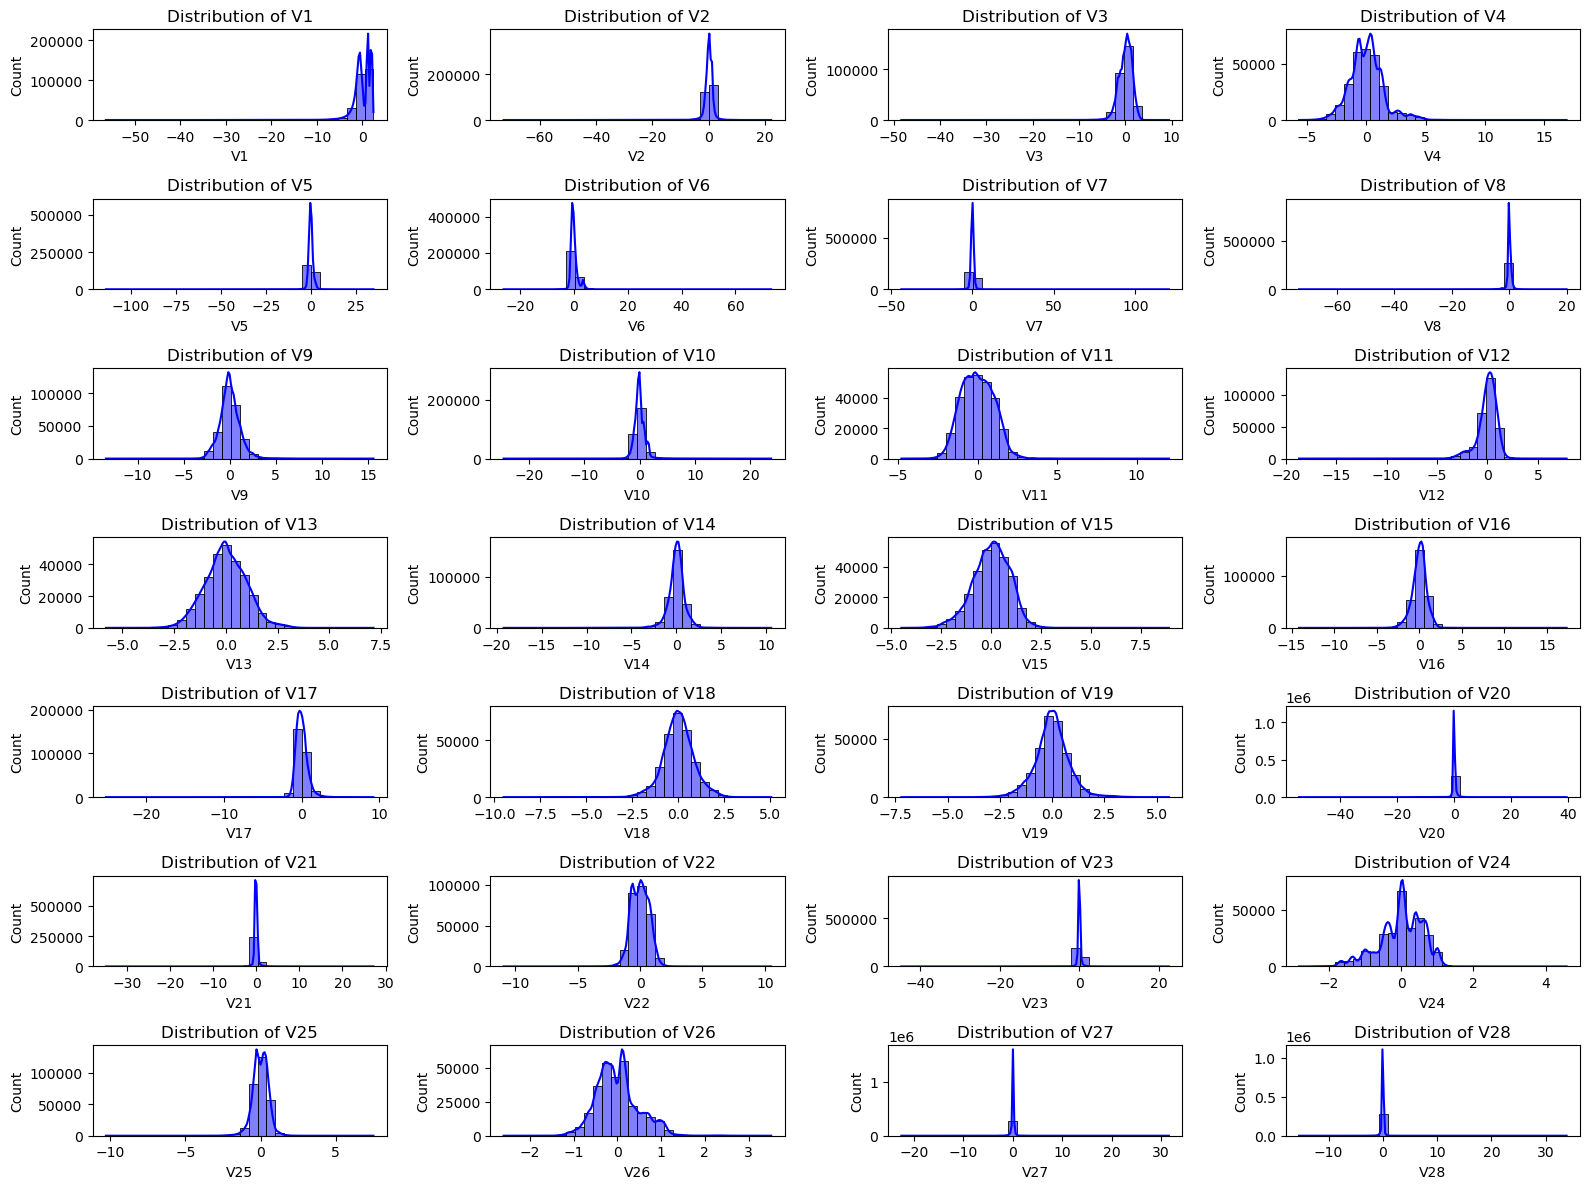

In [346]:
def plot_feature_distributions(df):
    plt.figure(figsize=(16, 12))
    for i in range(1, 29):  # V1 to V28
        plt.subplot(7, 4, i)
        sns.histplot(df[f'V{i}'], bins=30, kde=True, color='blue')
        plt.title(f'Distribution of V{i}')
    plt.tight_layout()
    plt.show()


plot_feature_distributions(card)


# XGBoost
## 1. Oversampling minority class

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.91      0.85      0.88       136

    accuracy                           1.00     85443
   macro avg       0.96      0.93      0.94     85443
weighted avg       1.00      1.00      1.00     85443

XGBoost Confusion Matrix:
[[85296    11]
 [   20   116]]


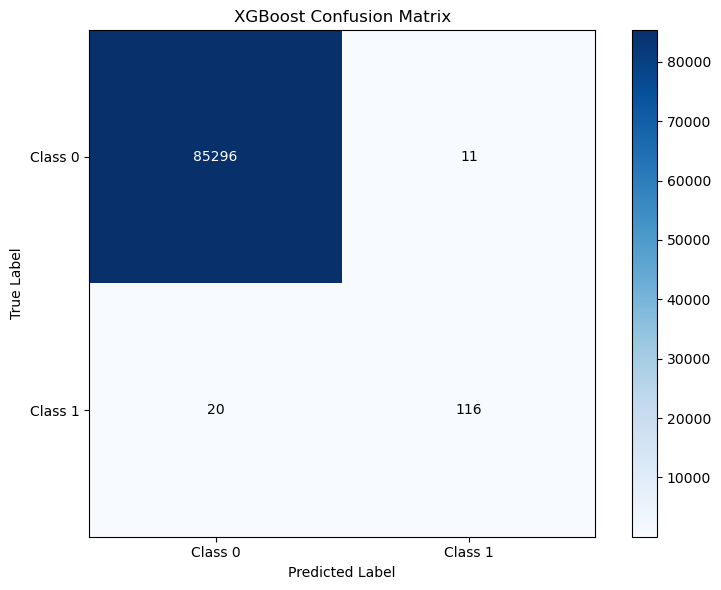

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [321]:
def train_xgboost_model(data):
    """
    Trains an XGBoost model on the provided dataset, evaluates its performance, and plots the confusion matrix.

    This function performs the following steps:
    1. Separates features and target from the provided dataset.
    2. Splits the data into training and testing sets.
    3. Scales the features using StandardScaler.
    4. Handles class imbalance by oversampling the minority class.
    5. Trains an XGBoost model on the upsampled training data.
    6. Makes predictions on the test data.
    7. Evaluates the model using classification report and confusion matrix.
    8. Plots the confusion matrix.

    Parameters:
    data (pd.DataFrame): The input dataset containing features and the target column 'Class'.

    Returns:
    xgb_model (xgb.XGBClassifier): The trained XGBoost model.
    """
    # Separate features and target
    X = data.drop('Class', axis=1)
    y = data['Class']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Handle class imbalance by random oversampling
    X_train_df = pd.DataFrame(X_train)
    X_train_df['Class'] = y_train.values

    # Separate majority and minority classes
    majority_class = X_train_df[X_train_df['Class'] == 0]
    minority_class = X_train_df[X_train_df['Class'] == 1]

    # Oversample minority class
    minority_class_upsampled = minority_class.sample(n=len(majority_class), replace=True, random_state=42)

    # Combine majority class with upsampled minority class
    upsampled_train = pd.concat([majority_class, minority_class_upsampled])

    # Split back to features and target
    X_train_upsampled = upsampled_train.drop('Class', axis=1).values
    y_train_upsampled = upsampled_train['Class'].values

    # Train XGBoost model
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, max_depth=6, eta= 0.3,)
    xgb_model.fit(X_train_upsampled, y_train_upsampled)

    # Make predictions
    xgb_pred = xgb_model.predict(X_test)
    xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print("XGBoost Classification Report:")
    print(classification_report(y_test, xgb_pred))

    # Confusion Matrix
    xgb_cm = confusion_matrix(y_test, xgb_pred)
    print("XGBoost Confusion Matrix:")
    print(xgb_cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(xgb_cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    plt.yticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    threshold = xgb_cm.max() / 2
    for i in range(xgb_cm.shape[0]):
        for j in range(xgb_cm.shape[1]):
            color = "white" if xgb_cm[i, j] > threshold else "black"
            plt.text(j, i, format(xgb_cm[i, j], 'd'), ha='center', va='center', color=color)
    plt.title('XGBoost Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return xgb_model


train_xgboost_model(card)


## Built-in Handling of Class Imbalance

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.92      0.85      0.89       136

    accuracy                           1.00     85443
   macro avg       0.96      0.93      0.94     85443
weighted avg       1.00      1.00      1.00     85443

XGBoost Confusion Matrix:
[[85297    10]
 [   20   116]]


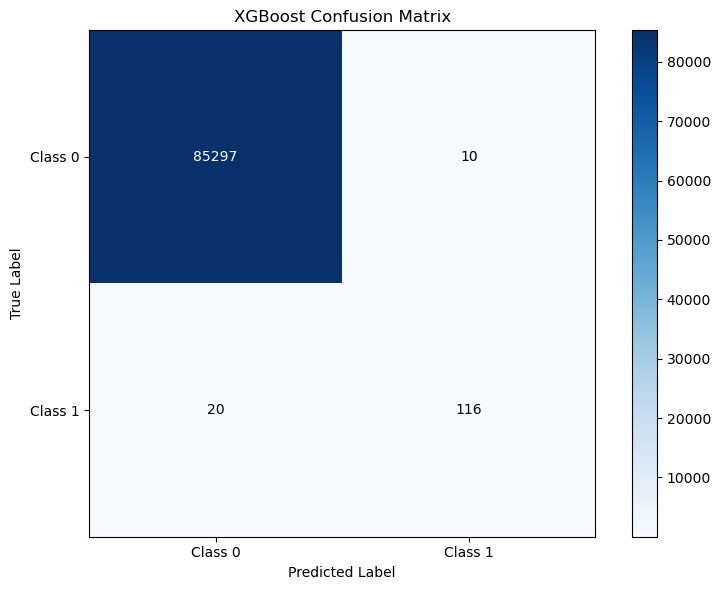

In [402]:
def train_xgboost_model(data):
    """
    Trains an XGBoost model on the provided dataset, evaluates its performance, and plots the confusion matrix.

    This function performs the following steps:
    1. Separates features and target from the provided dataset.
    2. Splits the data into training and testing sets.
    3. Scales the features using StandardScaler.
    4. Handles class imbalance using the scale_pos_weight parameter.
    5. Trains an XGBoost model on the training data.
    6. Makes predictions on the test data.
    7. Evaluates the model using classification report and confusion matrix.
    8. Plots the confusion matrix.

    Parameters:
    data (pd.DataFrame): The input dataset containing features and the target column 'Class'.

    Returns:
    xgb_model (xgb.XGBClassifier): The trained XGBoost model.
    """
    # Separate features and target
    X = data.drop('Class', axis=1)
    y = data['Class']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Calculate the scale_pos_weight parameter
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # Train XGBoost model with scale_pos_weight to handle class imbalance
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic', 
        eval_metric='logloss', 
        use_label_encoder=False, 
        max_depth=6, 
        eta=0.3,
        scale_pos_weight=scale_pos_weight
    )
    xgb_model.fit(X_train, y_train)

    # Make predictions
    xgb_pred = xgb_model.predict(X_test)
    xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print("XGBoost Classification Report:")
    print(classification_report(y_test, xgb_pred))

    # Confusion Matrix
    xgb_cm = confusion_matrix(y_test, xgb_pred)
    print("XGBoost Confusion Matrix:")
    print(xgb_cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(xgb_cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    plt.yticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    threshold = xgb_cm.max() / 2
    for i in range(xgb_cm.shape[0]):
        for j in range(xgb_cm.shape[1]):
            color = "white" if xgb_cm[i, j] > threshold else "black"
            plt.text(j, i, format(xgb_cm[i, j], 'd'), ha='center', va='center', color=color)
    plt.title('XGBoost Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return xgb_model



trained_model = train_xgboost_model(card)


# LightGBM model
### 1. Oversampling minority class

[LightGBM] [Info] Number of positive: 199008, number of negative: 199008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7647
[LightGBM] [Info] Number of data points in the train set: 398016, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.83      0.84      0.83       136

    accuracy                           1.00     85443
   macro avg       0.91      0.92      0.92     85443
weighted avg       1.00      1.00      1.00     85443

LightGBM Confusion Matrix:
[[85283    24]
 [   22   114]]


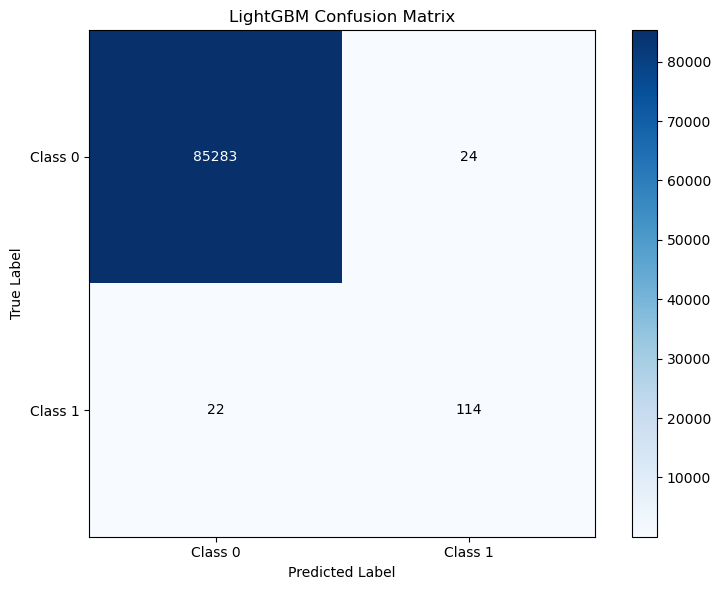

LGBMClassifier(metric='binary_logloss', objective='binary')

In [326]:
def train_lightgbm_model(data):
    """
    Trains a LightGBM model on the provided dataset, evaluates its performance, and plots the confusion matrix.

    This function performs the following steps:
    1. Separates features and target from the provided dataset.
    2. Splits the data into training and testing sets.
    3. Scales the features using StandardScaler.
    4. Handles class imbalance by oversampling the minority class.
    5. Trains a LightGBM model on the upsampled training data.
    6. Makes predictions on the test data.
    7. Evaluates the model using classification report and confusion matrix.
    8. Plots the confusion matrix.

    Parameters:
    data (pd.DataFrame): The input dataset containing features and the target column 'Class'.

    Returns:
    lgb_model (lgb.LGBMClassifier): The trained LightGBM model.
    """
    # Separate features and target
    X = data.drop('Class', axis=1)
    y = data['Class']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Handle class imbalance by random oversampling
    X_train_df = pd.DataFrame(X_train)
    X_train_df['Class'] = y_train.values

    # Separate majority and minority classes
    majority_class = X_train_df[X_train_df['Class'] == 0]
    minority_class = X_train_df[X_train_df['Class'] == 1]

    # Oversample minority class
    minority_class_upsampled = minority_class.sample(n=len(majority_class), replace=True, random_state=42)

    # Combine majority class with upsampled minority class
    upsampled_train = pd.concat([majority_class, minority_class_upsampled])

    # Split back to features and target
    X_train_upsampled = upsampled_train.drop('Class', axis=1).values
    y_train_upsampled = upsampled_train['Class'].values

    # Train LightGBM model
    lgb_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss')
    lgb_model.fit(X_train_upsampled, y_train_upsampled)

    # Make predictions
    lgb_pred = lgb_model.predict(X_test)
    lgb_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print("LightGBM Classification Report:")
    print(classification_report(y_test, lgb_pred))

    # Confusion Matrix
    lgb_cm = confusion_matrix(y_test, lgb_pred)
    print("LightGBM Confusion Matrix:")
    print(lgb_cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(lgb_cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    plt.yticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    threshold = lgb_cm.max() / 2
    for i in range(lgb_cm.shape[0]):
        for j in range(lgb_cm.shape[1]):
            color = "white" if lgb_cm[i, j] > threshold else "black"
            plt.text(j, i, format(lgb_cm[i, j], 'd'), ha='center', va='center', color=color)
    plt.title('LightGBM Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    return lgb_model


train_lightgbm_model(card)


## 2. Built-in Handling of Class Imbalance

[LightGBM] [Info] Number of positive: 356, number of negative: 199008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333731 -> initscore=-0.691360
[LightGBM] [Info] Start training from score -0.691360
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.90      0.85      0.87       136

    accuracy                           1.00     85443
   macro avg       0.95      0.92      0.94     85443
weighted avg       1.00      1.00      1.00     85443

LightGBM Confusion Matrix:
[[85294    13]
 [   21   115]]


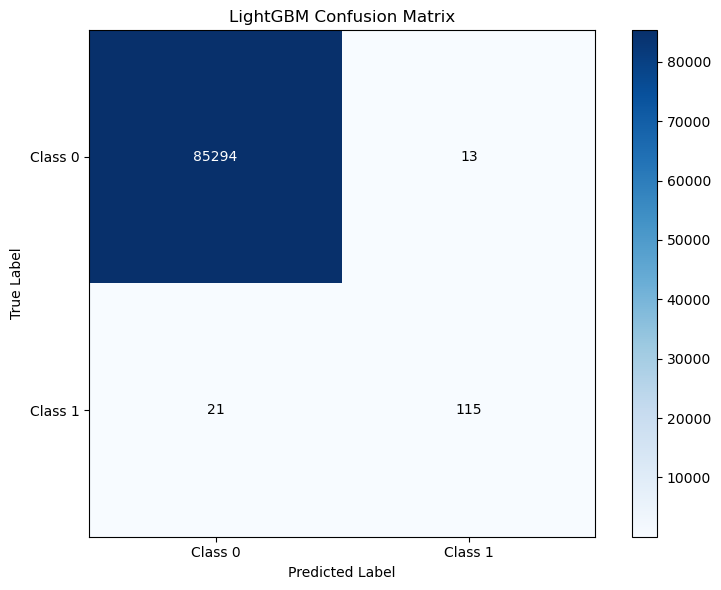

In [406]:
def train_lightgbm_model(data):
    """
    Trains a LightGBM model on the provided dataset, evaluates its performance, and plots the confusion matrix.

    This function performs the following steps:
    1. Separates features and target from the provided dataset.
    2. Splits the data into training and testing sets.
    3. Scales the features using StandardScaler.
    4. Handles class imbalance using the class_weight parameter.
    5. Trains a LightGBM model on the training data.
    6. Makes predictions on the test data.
    7. Evaluates the model using classification report and confusion matrix.
    8. Plots the confusion matrix.

    Parameters:
    data (pd.DataFrame): The input dataset containing features and the target column 'Class'.

    Returns:
    lgb_model (lgb.LGBMClassifier): The trained LightGBM model.
    """
    # Separate features and target
    X = data.drop('Class', axis=1)
    y = data['Class']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Calculate the class_weight parameter
    class_weight = {0: 1, 1: len(y_train) / (2 * len(y_train[y_train == 1]))}

    # Train LightGBM model with class_weight to handle class imbalance
    lgb_model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        class_weight=class_weight
    )
    lgb_model.fit(X_train, y_train)

    # Make predictions
    lgb_pred = lgb_model.predict(X_test)
    lgb_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print("LightGBM Classification Report:")
    print(classification_report(y_test, lgb_pred))

    # Confusion Matrix
    lgb_cm = confusion_matrix(y_test, lgb_pred)
    print("LightGBM Confusion Matrix:")
    print(lgb_cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(lgb_cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    plt.yticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    threshold = lgb_cm.max() / 2
    for i in range(lgb_cm.shape[0]):
        for j in range(lgb_cm.shape[1]):
            color = "white" if lgb_cm[i, j] > threshold else "black"
            plt.text(j, i, format(lgb_cm[i, j], 'd'), ha='center', va='center', color=color)
    plt.title('LightGBM Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    return lgb_model


trained_model = train_lightgbm_model(card)


# Autoencoders

Epoch 1/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9772 - val_loss: 0.7802
Epoch 2/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7808 - val_loss: 0.7495
Epoch 3/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7726 - val_loss: 0.7374
Epoch 4/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7540 - val_loss: 0.7319
Epoch 5/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7342 - val_loss: 0.7276
Epoch 6/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7435 - val_loss: 0.7252
Epoch 7/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7416 - val_loss: 0.7275
Epoch 8/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7349 - val_loss: 0.7233
Epoch 9/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7370 - val_loss: 0.7219
Epoch 10/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7248 - val_loss: 0.7212
Epoch 11/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7306 - val_loss: 0.7207
Epoch 12/50
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

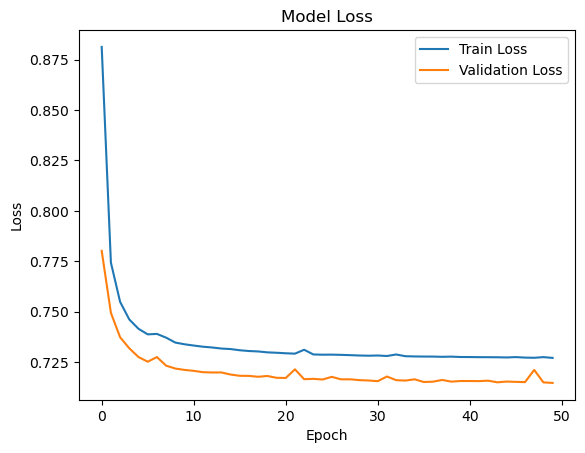

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step


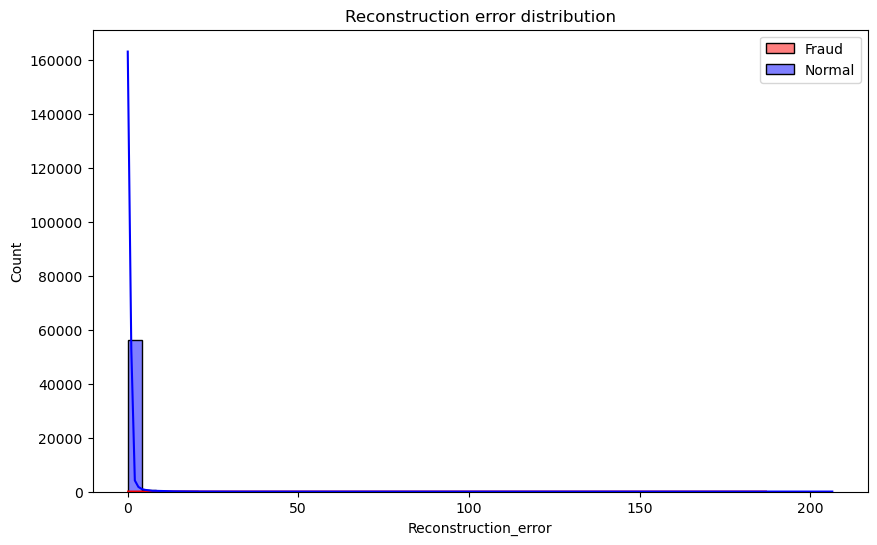

Confusion Matrix:
 [[56832    32]
 [   73    25]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.44      0.26      0.32        98

    accuracy                           1.00     56962
   macro avg       0.72      0.63      0.66     56962
weighted avg       1.00      1.00      1.00     56962



In [383]:
def train_autoencoder(df, encoding_dim=15, epochs=50, batch_size=256, test_size=0.2, threshold_percentile=99.9):
    """
    Trains an autoencoder model for anomaly detection on the provided dataset.

    Parameters:
    df (pd.DataFrame): The input dataframe containing features and the target 'Class'.
    encoding_dim (int): Size of the encoding (bottleneck) layer.
    epochs (int): Number of epochs to train the model.
    batch_size (int): Batch size for training.
    test_size (float): Proportion of the dataset to include in the test split.
    threshold_percentile (int): Percentile of reconstruction error to set the threshold for anomaly detection.

    Returns:
    Model: Trained autoencoder model.
    float: Threshold value used for anomaly detection.
    pd.DataFrame: DataFrame containing reconstruction errors and true class labels.
    """
    
    # Separate features and target
    X = df.drop(columns=['Class'])
    y = df['Class']

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=test_size, random_state=42)

    # Define the autoencoder model
    input_layer = Input(shape=(X_train.shape[1],))
    encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
    decoded = Dense(X_train.shape[1], activation='sigmoid')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train the model
    history = autoencoder.fit(X_train, X_train, 
                              epochs=epochs, 
                              batch_size=batch_size, 
                              shuffle=True, 
                              validation_data=(X_test, X_test),
                              verbose=1)

    # Plot training history
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Evaluate the model on test data
    encoded_data = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - encoded_data, 2), axis=1)
    error_df = pd.DataFrame({'Reconstruction_error': mse, 'True_class': y_test})

    # Plot the reconstruction error distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(error_df[error_df['True_class'] == 1]['Reconstruction_error'], bins=50, kde=True, color='red', label='Fraud')
    sns.histplot(error_df[error_df['True_class'] == 0]['Reconstruction_error'], bins=50, kde=True, color='blue', label='Normal')
    plt.legend(loc='upper right')
    plt.title('Reconstruction error distribution')
    plt.show()

    # Set threshold for anomaly detection
    threshold = np.percentile(mse, threshold_percentile)

    # Make predictions based on the threshold
    predictions = [1 if e > threshold else 0 for e in mse]

    # Confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, predictions)
    print("Confusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", classification_report(y_test, predictions))

    return autoencoder, threshold, error_df


model, threshold, errors = train_autoencoder(card)


[LightGBM] [Info] Number of positive: 356, number of negative: 199008
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333731 -> initscore=-0.691360
[LightGBM] [Info] Start training from score -0.691360
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.90      0.85      0.87       136

    accuracy                           1.00     85443
   macro avg       0.95      0.92      0.94     85443
weighted avg       1.00      1.00      1.00     85443

LightGBM Confusion Matrix:
[[85294    13]
 [   21   115]]


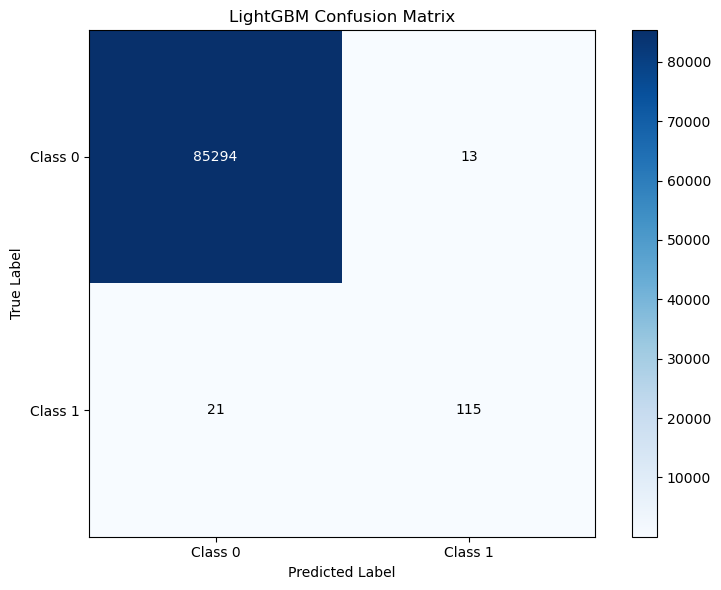

In [404]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb

def train_lightgbm_model(data):
    """
    Trains a LightGBM model on the provided dataset, evaluates its performance, and plots the confusion matrix.

    This function performs the following steps:
    1. Separates features and target from the provided dataset.
    2. Splits the data into training and testing sets.
    3. Scales the features using StandardScaler.
    4. Handles class imbalance using the class_weight parameter.
    5. Trains a LightGBM model on the training data.
    6. Makes predictions on the test data.
    7. Evaluates the model using classification report and confusion matrix.
    8. Plots the confusion matrix.

    Parameters:
    data (pd.DataFrame): The input dataset containing features and the target column 'Class'.

    Returns:
    lgb_model (lgb.LGBMClassifier): The trained LightGBM model.
    """
    # Separate features and target
    X = data.drop('Class', axis=1)
    y = data['Class']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Calculate the class_weight parameter
    class_weight = {0: 1, 1: len(y_train) / (2 * len(y_train[y_train == 1]))}

    # Train LightGBM model with class_weight to handle class imbalance
    lgb_model = lgb.LGBMClassifier(
        objective='binary',
        metric='binary_logloss',
        class_weight=class_weight
    )
    lgb_model.fit(X_train, y_train)

    # Make predictions
    lgb_pred = lgb_model.predict(X_test)
    lgb_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print("LightGBM Classification Report:")
    print(classification_report(y_test, lgb_pred))

    # Confusion Matrix
    lgb_cm = confusion_matrix(y_test, lgb_pred)
    print("LightGBM Confusion Matrix:")
    print(lgb_cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(lgb_cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    plt.yticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    threshold = lgb_cm.max() / 2
    for i in range(lgb_cm.shape[0]):
        for j in range(lgb_cm.shape[1]):
            color = "white" if lgb_cm[i, j] > threshold else "black"
            plt.text(j, i, format(lgb_cm[i, j], 'd'), ha='center', va='center', color=color)
    plt.title('LightGBM Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    return lgb_model


trained_model = train_lightgbm_model(card)
